In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
import kagglehub
from typing import Dict, List, Tuple

In [3]:
dataset_path = kagglehub.dataset_download("parsasam/captcha-dataset")
dataset_path = Path(dataset_path)

In [4]:
CHARACTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
NUM_CLASSES: int = len(CHARACTERS)
CHAR_TO_INDEX = {char: idx for idx, char in enumerate(CHARACTERS)}
INDEX_TO_CHAR = {idx: char for char, idx in CHAR_TO_INDEX.items()}
CAPTCHA_LENGTH: int = 5  # Captchas are exactly 5 characters long

def encode_label(label: str) -> torch.Tensor:
    assert len(label) == 5, "Label must be exactly 5 characters long."
    indices = [CHAR_TO_INDEX[char] for char in label]
    one_hot = torch.zeros(len(label), NUM_CLASSES)
    for i, index in enumerate(indices):
        one_hot[i][index] = 1
    return one_hot

def decode_label(encoded_label: torch.Tensor) -> str:
    decoded_chars = []
    for i in range(encoded_label.size(0)):
        index = torch.argmax(encoded_label[i]).item()
        decoded_chars.append(INDEX_TO_CHAR[index])
    return ''.join(decoded_chars)

# Test encoding and decoding
label: str = "A1bCd"
encoded_label: torch.Tensor = encode_label(label)
print("Encoded Label:\n", encoded_label)

decoded_label: str = decode_label(encoded_label)
print("Decoded Label:", decoded_label)


Encoded Label:
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [5]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((40, 150)),
    transforms.ToTensor()
])

class CaptchaDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]  # Assuming .jpg files
        self.num_chars = 5  # Fixed length of label (5 characters)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label = img_name.split('.')[0]  # Extract label from filename (without the .jpg extension)
        img_path = os.path.join(self.img_dir, img_name)
        
        # Open the image and apply the transform (if any)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label_one_hot = encode_label(label)
        
        return image, label_one_hot

In [6]:
# Create the dataset and dataloaders
dataset = CaptchaDataset(img_dir=dataset_path, transform=transform)

train_ratio = 0.8
test_ratio = 1 - train_ratio

# Split the dataset into training and testing sets
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
class CaptchaCNN(nn.Module):
    def __init__(self):
        super(CaptchaCNN, self).__init__()

        # Define the individual convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Define the MaxPool layers
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dummy input to calculate the output size after convolutions
        self.dummy_input = torch.zeros(1, 3, 40, 150)
        conv_output = self._forward_conv(self.dummy_input)  # Get output shape after convolution
        conv_output_size = conv_output.view(1, -1).size(1)  # Flatten the output and get size
        
        # Define fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.fc2 = nn.Linear(256, CAPTCHA_LENGTH * NUM_CLASSES)
    
    def _forward_conv(self, x):
        # Pass through the convolutional layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        return x

    def forward(self, x):
        # Pass through convolution layers
        x = self._forward_conv(x)

        # Flatten the output of the convolutional layers
        x = x.flatten(start_dim=1)

        # Pass through fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # Reshape to match the desired output format
        return x.view(-1, CAPTCHA_LENGTH, NUM_CLASSES)

In [8]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CaptchaCNN()
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def load_checkpoint(model, optimizer, checkpoints_dir="checkpoints"):
    # List all checkpoint files in the directory
    checkpoint_files = [f for f in os.listdir(checkpoints_dir) if f.endswith(".pth")]
    
    # If no checkpoint exists, return the model and optimizer state without modification
    if not checkpoint_files:
        print("No checkpoint found, starting fresh.")
        return model, optimizer, 0, []
    
    # Find the most recent checkpoint (by sorting the files)
    latest_checkpoint = max(checkpoint_files, key=lambda f: int(f.split('_')[2].split('.')[0]))  # Sorting by epoch number
    checkpoint_path = os.path.join(checkpoints_dir, latest_checkpoint)
    
    # Load checkpoint data
    checkpoint = torch.load(checkpoint_path)
    
    # Restore model state, optimizer state, and other checkpoint data
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Get the starting epoch and loss history
    starting_epoch = checkpoint['epoch']
    loss_history = checkpoint['loss_history']
    
    print(f"Loaded checkpoint from epoch {starting_epoch}")
    
    return model, optimizer, starting_epoch, loss_history


In [10]:
model, optimizer, start_epoch, loss_history = load_checkpoint(model, optimizer)

print(f"Loss history length: {len(loss_history)}")

Loaded checkpoint from epoch 10
Loss history length: 28270


In [11]:
def train_model(model, train_loader, optimizer, criterion, epochs=10, 
                print_every=100, checkpoints_dir="checkpoints", starting_epoch=0, loss_history=None):
    if loss_history is None:
        loss_history = []  # Initialize loss history if not provided
    
    total_batches = len(train_loader)  # Total number of batches per epoch
    
    # Ensure the checkpoints directory exists
    os.makedirs(checkpoints_dir, exist_ok=True)
    
    model.train()
    for epoch in range(starting_epoch, epochs):  # Start from the checkpoint's epoch
        total_loss = 0
        start_epoch_time = time.time()  # Record start time of the epoch
        
        for batch_idx, (images, labels) in enumerate(train_loader):           
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Calculate total elapsed time since the start of training
            total_elapsed_time = time.time() - start_epoch_time
            avg_batch_time = total_elapsed_time / (batch_idx + 1)

            # Print loss and total elapsed time at specified frequency
            if batch_idx % print_every == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{total_batches}], Loss: {loss.item():.4f}, "
                      f"Total Elapsed Time: {total_elapsed_time:.2f}s, Avg Time per Batch: {avg_batch_time:.4f}s")
                
            loss_history.append(loss.item())
        
        # Save checkpoint at the end of the epoch
        checkpoint_filename = f"model_epoch_{epoch+1}.pth"
        checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename)
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_history': loss_history,
        }, checkpoint_path)
        print(f"Saved model checkpoint for epoch [{epoch+1}/{epochs}] to {checkpoint_filename}")
        
        # Calculate total epoch time and print the information
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - start_epoch_time
        print(f"Epoch {epoch+1}/{epochs}, Epoch Time: {epoch_time:.2f}s")
     
    return loss_history


In [12]:
history = train_model(
    model=model,
    train_loader=train_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=10,
    print_every=750,
    checkpoints_dir='checkpoints',
    starting_epoch=start_epoch,
    loss_history=loss_history
)

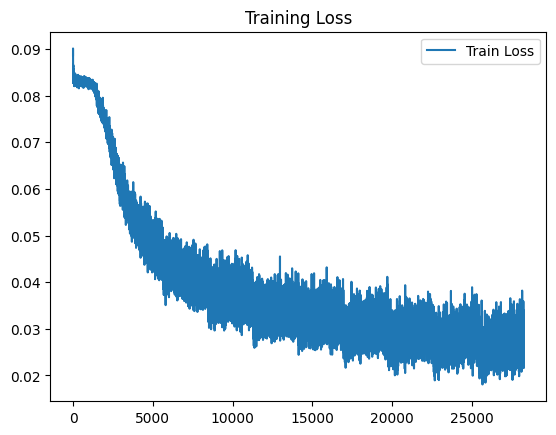

In [28]:
# Function to plot training results
def plot_results(history):
    plt.plot(history, label='Train Loss')
    plt.legend()
    plt.title('Training Loss')
    plt.show()

plot_results(loss_history[25:])

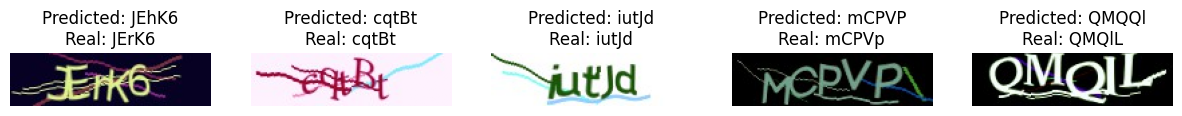

In [14]:
# Function to predict labels from the model
def predict(model, dataloader, device):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    outputs = model(images)
    predicted_labels = []
    for output in outputs:
        predicted_label = decode_label(output)
        predicted_labels.append(predicted_label)
    return images.cpu(), predicted_labels, labels

# Get some images and their predicted labels
images, predicted_labels, real_labels = predict(model, test_dataloader, device)

# Display a few images and their predicted labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i].permute(1, 2, 0))
    ax.set_title(f"Predicted: {predicted_labels[i]}\nReal: {decode_label(real_labels[i])}")
    ax.axis('off')
plt.show()

In [24]:
def evaluate_model(model, dataloader, device):
    model.eval()
    results = {
        "total_captchas": 0,
        "correct_captchas": 0,
        "total_letters": 0,
        "correct_letters": 0,
    }
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            
            for output, label in zip(outputs, labels):
                predicted_label = decode_label(output)
                real_label = decode_label(label)
                
                results["total_captchas"] += 1
                results["total_letters"] += CAPTCHA_LENGTH
                
                if predicted_label == real_label:
                    results["correct_captchas"] += 1

                results["correct_letters"] += sum(p == r for p, r in zip(predicted_label, real_label))
        return results

results = evaluate_model(model, test_dataloader, device)

In [25]:
print(f"Correct Captchas: {results["correct_captchas"]}/{results["total_captchas"]} ({results["correct_captchas"]/results["total_captchas"]:.2%})")
print(f"Correct Letters: {results["correct_letters"]}/{results["total_letters"]} ({results["correct_letters"]/results["total_letters"]:.2%})")

Correct Captchas: 7416/22613 (32.80%)
Correct Letters: 86606/113065 (76.60%)
